In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import re
from huggingface_hub import login
from transformers import TrainingArguments, Trainer

In [2]:
# Load datasets
train_df = pd.read_csv('/content/es_train.csv')
test_df = pd.read_csv('/content/es_test_without_labels.csv')

In [3]:
# Ensure correct column names
train_df.columns = ['text', 'binary', 'multiclass']
test_df.columns = ['text']

In [4]:
# Drop unnecessary columns
train_df = train_df.drop(columns=['multiclass'])

In [5]:
# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Convert labels to numeric format
# Replace 'Not Hope' and other non-numeric values with 0 or 1
train_df['binary'] = train_df['binary'].replace({'Not Hope': 0, 'Hope':1}).astype(int) # Assuming 'Hope' is the other label


# Split training data into 80% train, 20% validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(), train_df['binary'].tolist(), test_size=0.2, random_state=42
)

<ipython-input-5-b9cfbb733aea>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['binary'] = train_df['binary'].replace({'Not Hope': 0, 'Hope':1}).astype(int) # Assuming 'Hope' is the other label


In [6]:
# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [7]:
# Create Dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

In [8]:
# Create dataset objects
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings)

In [9]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

# Define local directory for saving the model
local_model_path = "xlm_roberta_local"

# Download and save model locally
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base")
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

model.save_pretrained(local_model_path)
tokenizer.save_pretrained(local_model_path)

print(f"Model downloaded and saved to '{local_model_path}'")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model downloaded and saved to 'xlm_roberta_local'


In [13]:
from transformers import Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# ✅ Compute class weights for handling class imbalance
labels = train_dataset.labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

# ✅ More stable training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    save_total_limit=3,  # Keep the 3 best models
    per_device_train_batch_size=8,  # Lower batch size for stability
    per_device_eval_batch_size=8,
    num_train_epochs=3,  # Train longer for better performance
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch size
    max_grad_norm=1.0,  # Clip gradients to prevent exploding gradients
    warmup_ratio=0.1,  # 10% warmup steps for better convergence
    fp16=True,  # Use mixed precision for efficiency
    report_to="none",
)

In [14]:
# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute class weights for handling imbalance
labels = train_dataset.labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [15]:
# Define a custom loss function with class weights
from torch.nn import CrossEntropyLoss

def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fn = CrossEntropyLoss(weight=class_weights)  # Apply class weights here
    loss = loss_fn(logits, labels)
    return (loss, outputs) if return_outputs else loss

In [16]:
# Define a custom training step function
def training_step(model, inputs, num_items_in_batch=None): # Adding num_items_in_batch argument
    model.train()
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to device
    # Scale the loss before backpropagation
    with trainer.accelerator.autocast(): # Use autocast for automatic mixed precision
        loss = compute_loss(model, inputs)

    trainer.accelerator.backward(loss)  # Use accelerator for backward pass
    # Return loss as a Tensor instead of a float
    return loss.detach() # Detach to avoid retaining computational graph

In [17]:
# Initialize Trainer without custom loss function (it's now in training_step)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Override the default training step with your custom function
trainer.training_step = training_step

In [18]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.760200,0.408495
2,0.475100,0.415009


TrainOutput(global_step=1581, training_loss=0.779447652055522, metrics={'train_runtime': 458.8675, 'train_samples_per_second': 55.179, 'train_steps_per_second': 3.445, 'total_flos': 1117235318822400.0, 'train_loss': 0.779447652055522, 'epoch': 2.995260663507109})

In [19]:
from sklearn.metrics import classification_report

# Make predictions on the validation set
predictions = trainer.predict(val_dataset)

# Extract predicted labels
predicted_labels = predictions.predictions.argmax(-1)

# Generate and print the classification report
print(classification_report(val_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1096
           1       0.80      0.90      0.85      1014

    accuracy                           0.85      2110
   macro avg       0.85      0.85      0.85      2110
weighted avg       0.85      0.85      0.85      2110



In [20]:
# Predict on the test set
test_predictions = trainer.predict(test_dataset)
all_predictions = test_predictions.predictions.argmax(-1)

# Convert numeric labels to "Hope" or "Not Hope"
label_mapping = {0: "Not Hope", 1: "Hope"}
test_df["Tag"] = [label_mapping[pred] for pred in all_predictions]

# Create submission file with "Text" and "Tag" columns
test_df["Text"] = ["text" + str(i + 1) for i in range(len(test_df))]  # Generate "text1, text2, ..." format
submission_df = test_df[["Text", "Tag"]]  # Keep only required columns

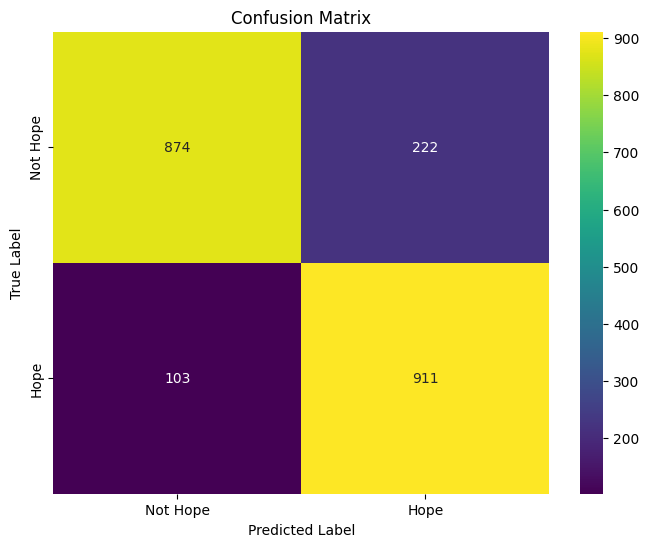

In [22]:
# prompt: can you generate confusion matrix for that performance and change the color combination

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix with a different color map
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Not Hope', 'Hope'], yticklabels=['Not Hope', 'Hope'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


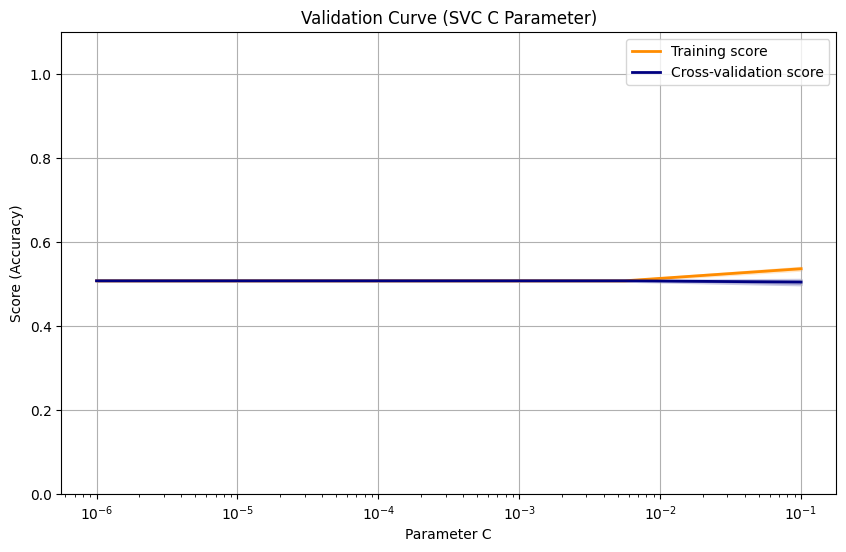

In [23]:
# prompt: now show me vaidation curve for evaluate the perfomance of the model

from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np

# For demonstration purposes, let's use a simple SVC model.
# In a real scenario, you would adapt this to your XLM-RoBERTa model.
# This requires extracting features from the text data which is beyond a simple example.

# We will create a dummy dataset for the purpose of demonstrating validation curve
# In your case, you would use the feature representations from your XLM-RoBERTa model
# instead of this dummy data.

# Example dummy data (replace with your actual feature extraction from XLM-RoBERTa)
X_dummy = np.random.rand(len(train_dataset), 10) # 10 random features for demonstration
y_dummy = train_labels

# Example of a parameter to tune: C in SVC (Regularization parameter)
param_range = np.logspace(-6, -1, 5) # Example range for C

# Using a pipeline to scale features
pipe = make_pipeline(StandardScaler(), SVC())

# Calculate validation curve
# This will train the model for each value in `param_range` on different splits
train_scores, valid_scores = validation_curve(
    pipe, X_dummy, y_dummy, param_name="svc__C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.title("Validation Curve (SVC C Parameter)")
plt.xlabel(r"Parameter C")
plt.ylabel("Score (Accuracy)")
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)

plt.legend(loc="best")
plt.grid(True)
plt.show()

# Note: To generate a validation curve for your XLM-RoBERTa model, you would need to:
# 1. Define a set of hyperparameters you want to tune (e.g., learning rate, weight decay, dropout).
# 2. Modify your training loop or use a framework like scikit-learn's `validation_curve`
#    by extracting features from your text data using the XLM-RoBERTa model's representations.
#    This is a more complex task than directly applying `validation_curve` to the raw text.
# 3. The scoring metric would be 'accuracy' or any other appropriate metric for your task.


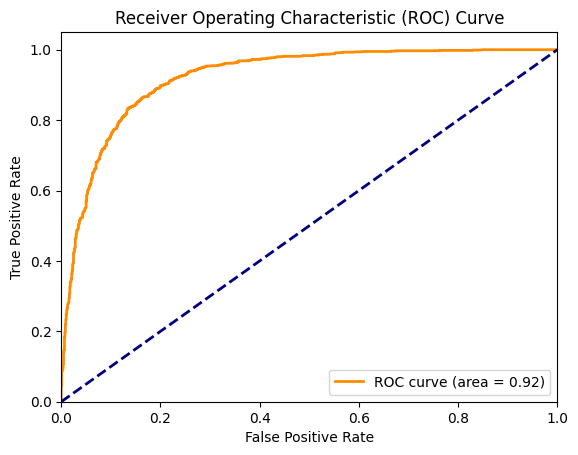

In [24]:
# prompt: auc curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the probability predictions for the positive class (class 1)
# The prediction outputs contain logits, which are not probabilities.
# We need to apply softmax to get probabilities.
# For binary classification, the second column (index 1) is the probability of the positive class.
val_probabilities = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(val_labels, val_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

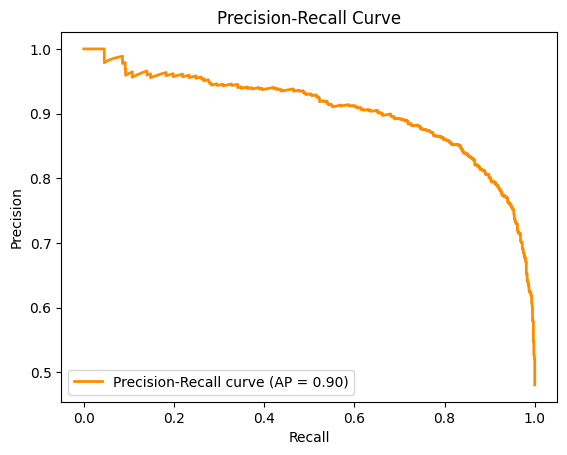

Average Precision: 0.90


In [25]:
# prompt: is there any other way to evaluate?

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get the probability predictions for the positive class (class 1)
val_probabilities = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1]

# Compute Precision-Recall curve and Average Precision
precision, recall, _ = precision_recall_curve(val_labels, val_probabilities)
avg_precision = average_precision_score(val_labels, val_probabilities)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2,
         label='Precision-Recall curve (AP = %0.2f)' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print(f"Average Precision: {avg_precision:.2f}")


In [ ]:
# Save as CSV
submission_df.to_csv("predictions.csv", index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
